# Custom One-Versus-All Logistic Regression

By: Haiyan Cai, Joe Sellett, and Cole Wagner

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import pinv
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
customers = pd.read_csv("customer_data.csv")

## Preparation and Overview

**[2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful.**

This dataset was collected by an automobile company for the purpose of customer segmentation. Customer segmentation is used by businesses to group customers into categories based on their purchasing behaviors. These behaviors may be influenced by factors such as income levels, previous spending habits, demographics, or any other data the company can obtain. This dataset was gathered because the automobile company aims to expand its current product offerings into new markets and seeks to understand potential customers in these markets. The company has successfully categorized its existing customers into four segments (A, B, C, D). The goal of our project is to accurately identify customer segments based on various variables, including gender, age, work experience, and more.

Customer segmentation is a crucial practice for marketers across all industries. A successful categorization of customer segments will be highly valuable to automobile manufacturers worldwide, enabling them to determine how to allocate their marketing resources and tailor their strategies effectively. To be considered useful, our model must outperform existing models. This dataset was previously used in a competition where the winners achieved 95% accuracy in identifying customer segments. However, we believe a model with an AUC above 0.8 would generally be considered valuable in this business context, while a model achieving an AUC above 0.9 would certainly be considered highly effective.

**[.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis (give reasoning). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).** 

### Data Preparation

Starting off, we will remove the ID and Var_1 variables from the data. The ID variable is unique to each row, so it does not provide any modeling value. Var_1 is anonymised, so we cannot know what it represents. There are also 796 duplicate rows which will be removed. There are a relatively small number of missing values in the ever_married, graduated, work_experience and family_size columns which we will impute with knn impute. Profession is the only column we will impute with mean, as there are many different professions. These ended up being imputed as “artist”, as there are over 2000 customers listed as artists in this dataset. Finally, we one-hot encoded our categorical variables (“gender”, “ever_married”, “graduated”, “profession”, “spending_score”) so that it would run smoothly in our model. Now, we are ready to move forward with training our data.

In [3]:
customers.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


#### Variable Selection

We will remove the ID and Var_1 variables from the data. The ID variable is unique to each row, so it does not provide any modeling value. Var_1 is anonymised, so we cannot know what it represents. 

In [4]:
customers_filtered = customers.drop(columns=["ID", "Var_1"])

#### Duplicate Data

In [5]:
sum(customers_filtered.duplicated())

719

From the above code, we can see that we have 719 duplicate rows, which we will remove.

In [6]:
customers_filtered.drop_duplicates(inplace=True)

#### Dealing with Missing Values

In [7]:
customers_filtered.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           77
Profession         123
Work_Experience    786
Spending_Score       0
Family_Size        326
Segmentation         0
dtype: int64

After many rounds of testing various imputation techniques (KNN, median, mode, etc.), we found that our test accuracy was consistently best when we simply removed all rows with missing values. This is likely due to the fact that the missing values are not random, and removing them allows us to avoid introducing bias into our model.

In [8]:
customers_filtered = customers_filtered.dropna()

#### Data Transformation

In order to prepare the data for modeling, we need to normalize all numeric columns and one-hot encode all categorical columns.

In [9]:
num_cols = ["Age", "Family_Size"]
cat_cols = customers_filtered.columns.difference(
    [*num_cols, "Segmentation"],
).tolist()

In [ ]:
# Normalize numerical columns
scaler = StandardScaler()
customers_filtered[num_cols] = scaler.fit_transform(
    customers_filtered[num_cols],
)

In [ ]:
# One-hot encode categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_cat_cols = one_hot_encoder.fit_transform(
    customers_filtered[cat_cols],
)

# Create a dataframe with the encoded columns
encoded_cat_df = pd.DataFrame(
    encoded_cat_cols,
    columns=one_hot_encoder.get_feature_names_out(cat_cols),
    index=customers_filtered.index,  # Ensure the index matches the original dataframe
)

# Concatenate the encoded columns with the original dataframe
customers_filtered = pd.concat(
    [customers_filtered.drop(columns=cat_cols), encoded_cat_df],
    axis=1,
)

**[.5 points] Divide your data into training and testing splits using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    customers_filtered.drop(columns=["Segmentation"]),
    customers_filtered["Segmentation"],
    test_size=0.2,
    random_state=42,
    stratify=customers_filtered["Segmentation"],
)

We would argue that this dataset is too small to do an 80/20 train/test split. Statistician Frank Harrell claims that around 20,000 rows are needed to perform a train/test split, and we only have about 6,000 rows. In this case, we favor using cross-validation because it allows us to use all of our data for model training while still quantifying model performance on many simulated test sets.

## Modeling

### Base Class (Steepest Descent)

Class definition pulled from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

**Modifications:**
- Docstrings
- type hints
- Options for L1, L2, and Elastic Net regularization

In [ ]:
class BinaryLogisticRegression:
    """Binary Logistic Regression using gradient descent.

    Parameters
    ----------
    eta : float
        Learning rate.
    iterations : int, optional (default=20)
        Number of iterations for the solver.
    C : float, optional (default=0.001)
        Constant applied to the regularization term.
    regularization : str, optional (default="L2")
        Type of regularization to apply. Options are "L1", "L2", or "Both".

    """

    def __init__(
        self,
        eta: float,
        iterations: int = 20,
        C: float = 0.001,
        regularization: str = "L2",
    ) -> None:
        """Initialize the BinaryLogisticRegression object.

        Parameters
        ----------
        eta : float
            Learning rate.
        iterations : int, optional (default=20)
            Number of iterations for the solver.
        C : float, optional (default=0.001)
            Constant applied to the regularization term.
        regularization : str, optional (default="L2")
            Type of regularization to apply. Options are "L1", "L2", or "Both".

        """
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.regularization = regularization
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self) -> str:
        """Return a message for the BinaryLogisticRegression object."""
        if hasattr(self, "w_"):
            return (
                "Binary Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        return "Untrained Binary Logistic Regression Object"

    # convenience, private:
    @staticmethod
    def _add_bias(X: np.array) -> np.array:
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta: np.array) -> np.array:
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    def _get_gradient(self, X, y):
        ydiff = (
            y - self.predict_proba(X, add_bias=False).ravel()
        )  # get y difference
        gradient = np.mean(
            X * ydiff[:, np.newaxis],
            axis=0,
        )  # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == "L1":
            gradient[1:] += -self.C * np.sign(self.w_[1:])
        elif self.regularization == "L2":
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization == "Both":
            gradient[1:] += (
                -self.C * np.sign(self.w_[1:]) - 2 * self.w_[1:] * self.C
            )

        return gradient

    # public:
    def predict_proba(
        self,
        X: np.array,
        add_bias: bool = True,
    ) -> np.array:
        """Predict the probability of the positive class.

        Parameters
        ----------
        X : np.array
            Input data.
        add_bias : bool, optional (default=True)
            Whether to add a bias term to the input data.

        """
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X: np.array) -> np.array:
        """Predict the discrete labels based on a cutoff of p > 0.5.

        Parameters
        ----------
        X : np.array
            Input data.

        """
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X: np.array, y: np.array) -> None:
        """Fit the model to data.

        Parameters
        ----------
        X : np.array
            Input data.
        y : np.array
            Target labels.

        """
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros(
            (num_features, 1),
        )  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta  # multiply by learning rate
            # add bacause maximizing

### Stochastic Gradient Descent

Class definition pulled from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

**Modifications:**
- Docstrings 
- Type hints
- Options for L1, L2, and Elastic Net regularization

In [ ]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    """Logistic Regression using stochastic gradient descent.

    Parameters
    ----------
    eta : float
        Learning rate.
    iterations : int, optional (default=20)
        Number of iterations for the solver.
    C : float, optional (default=0.001)
        Constant applied to the regularization term.
    regularization : str, optional (default="L2")
        Type of regularization to apply. Options are "L1", "L2", or "Both".

    """

    # stochastic gradient calculation
    def _get_gradient(self, X: np.array, y: np.array) -> np.array:
        # grab a subset of samples in a mini-batch
        mini_batch_size = 50
        idxs = np.random.choice(len(y), mini_batch_size)

        ydiff = (
            y[idxs] - self.predict_proba(X[idxs], add_bias=False).ravel()
        )  # get y difference (now scalar)
        gradient = np.mean(
            X[idxs] * ydiff[:, np.newaxis],
            axis=0,
        )  # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == "L1":
            gradient[1:] += -self.C * np.sign(self.w_[1:])
        elif self.regularization == "L2":
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization == "Both":
            gradient[1:] += (
                -self.C * np.sign(self.w_[1:]) - 2 * self.w_[1:] * self.C
            )
        return gradient

### Newton's Method Using Maximum Likelihood Estimation

Class definition pulled from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

**Modifications:**
- Docstrings
- Type hints
- Options for L1, L2, and Elastic Net regularization

In [ ]:
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    """Logistic Regression using Newton's method for optimization.

    Parameters
    ----------
    eta : float
        Learning rate.
    iterations : int, optional (default=20)
        Number of iterations for the solver.
    C : float, optional (default=0.001)
        Constant applied to the regularization term.
    regularization : str, optional (default="L2")
        Type of regularization to apply. Options are "L1", "L2", or "Both".

    """

    # just overwrite gradient function
    def _get_gradient(self, X: np.array, y: np.array) -> np.array:
        g = self.predict_proba(
            X,
            add_bias=False,
        ).ravel()  # get sigmoid value for all classes
        hessian = (
            X.T @ np.diag(g * (1 - g)) @ X - 2 * self.C
        )  # calculate the hessian

        ydiff = y - g  # get y difference
        gradient = np.sum(
            X * ydiff[:, np.newaxis],
            axis=0,
        )  # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == "L1":
            gradient[1:] += -self.C * np.sign(self.w_[1:])
        elif self.regularization == "L2":
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization == "Both":
            gradient[1:] += (
                -self.C * np.sign(self.w_[1:]) - 2 * self.w_[1:] * self.C
            )

        # Note the pinv() to make the hessian function inverse
        return pinv(hessian) @ gradient

### Newton's Method Using Mean Square Error as Objective Function

Class definition pulled from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

**Modifications:**
- Docstrings
- Type hints
- Implementation of MSE as objective function
- Options for L1, L2, and Elastic Net regularization

In [ ]:
class HessianBinaryLogisticRegressionMSE(BinaryLogisticRegression):
    """Logistic Regression using Newton's method optimized with Mean Squared Error (MSE).

    Parameters
    ----------
    eta : float
        Learning rate.
    iterations : int, optional (default=20)
        Number of iterations for the solver.
    C : float, optional (default=0.001)
        Regularization constant.
    regularization : str, optional (default="L2")
        Type of regularization to apply. Options are "L1", "L2", or "Both".

    """

    def _get_gradient(self, X: np.array, y: np.array) -> np.array:
        g = self.predict_proba(
            X,
            add_bias=False,
        ).ravel()  # get sigmoid value for all samples

        # Compute Mean Squared Error gradient
        ydiff = y - g  # error term
        gradient = (
            -2 * (X.T @ (ydiff * g * (1 - g))) / len(y)
        )  # Apply MSE gradient formula
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == "L1":
            gradient[1:] += -self.C * np.sign(self.w_[1:])
        elif self.regularization == "L2":
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization == "Both":
            gradient[1:] += (
                -self.C * np.sign(self.w_[1:]) - 2 * self.w_[1:] * self.C
            )

        # Compute Hessian based on MSE
        D = np.diag((2 * g * (1 - g)) / len(y))  # Diagonal matrix
        hessian = X.T @ D @ X - 2 * self.C * np.eye(
            X.shape[1],
        )  # MSE Hessian with regularization

        # Use pseudo-inverse to compute Newton step
        return pinv(hessian) @ gradient

Class definition pulled from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

**Modifications:**
- Docstrings
- Type hints
- Refactored `predict_proba()` to use list comprehension
- Added the `get_params()` and `set_params()` methods to allow for compatibility with Scikit-Learn's cross-validation tools
- Added `regularization` parameter to allow for L1, L2, and Elastic Net regularization

In [ ]:
class MultiClassLogisticRegression:
    """MultiClass Logistic Regression using One-Versus-All approach.

    Parameters
    ----------
    eta : float
        Learning rate.
    iterations : int, optional (default=20)
        Number of iterations for the solver.
    C : float, optional (default=0.0001)
        Constant applied to the regularization term.
    solver : class, optional (default=HessianBinaryLogisticRegression)
        Solver class to use for binary logistic regression.
    regularization : str, optional (default="L2")
            Type of regularization to use.
            Options are "L1" for Lasso, "L2" for Ridge, or "Both"
            for Elastic Net.

    """

    def __init__(
        self,
        eta: float,
        iterations: int = 20,
        C: float = 0.0001,
        regularization: str = "L2",
        solver: any = HessianBinaryLogisticRegression,
    ) -> None:
        """Initialize the MultiClassLogisticRegression object.

        Parameters
        ----------
        eta : float
            Learning rate.
        iterations : int, optional (default=20)
            Number of iterations for the solver.
        C : float, optional (default=0.0001)
            Constant applied to the regularization term.
        regularization : str, optional (default="L2")
            Type of regularization to use.
            Options are "L1" for Lasso, "L2" for Ridge, or "Both"
            for Elastic Net.
        solver : class, optional (default=HessianBinaryLogisticRegression)
            Solver class to use for binary logistic regression.

        """
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.regularization = regularization
        self.classifiers_ = []
        # internally we will store the weights as self.w_

    def __str__(self) -> str:
        """Return a message for the MultiClassLogisticRegression object."""
        if hasattr(self, "w_"):
            return (
                "MultiClass Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        return "Untrained MultiClass Logistic Regression Object"

    def fit(self, X: np.array, y: np.array) -> None:
        """Fit the model.

        Parameters
        ----------
        X : np.array
            Input data.
        y : np.array
            Target labels.

        """
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y))  # get each unique class value
        self.classifiers_ = []
        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = np.array(y == yval).astype(
                int,
            )  # create a binary problem
            # train the binary classifier for this class

            hblr = self.solver(
                eta=self.eta,
                iterations=self.iters,
                C=self.C,
                regularization=self.regularization,
            )
            hblr.fit(X, y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X: np.array) -> np.array:
        """Predict the probability of each class.

        Parameters
        ----------
        X : np.array
            Input data.

        """
        probs = [
            hblr.predict_proba(X).reshape((len(X), 1))
            for hblr in self.classifiers_
        ]
        return np.hstack(probs)  # make into single matrix

    def predict(self, X: np.array) -> np.array:
        """Predict the discrete labels.

        Parameters
        ----------
        X : np.array
            Input data.

        """
        return self.unique_[
            np.argmax(self.predict_proba(X), axis=1)
        ]  # take argmax along row

    def get_params(self, deep=True) -> dict:
        """Get the parameters of the model.

        Parameters
        ----------
        deep : bool, optional (default=True)
            Required parameter for compatibility with sklearn.

        Returns
        -------
        dict
            Parameters of the model.

        """
        return {
            "eta": self.eta,
            "iterations": self.iters,
            "C": self.C,
            "solver": self.solver,
            "regularization": self.regularization,
        }

    def set_params(self, **params: dict) -> None:
        """Set the parameters of the model.

        Parameters
        ----------
        **params : dict
            Parameters to set.

        """
        for key, value in params.items():
            if key in self.get_params():
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter: {key}")

### Compare Train/Test Split with 10-Fold CV on Full Dataset

In [ ]:
clf = MultiClassLogisticRegression(
    solver=HessianBinaryLogisticRegression,
    eta=0.1,
    regularization="Both",
)

In [19]:
clf.fit(x_train.values, y_train.values)
clf.predict(x_test.values)
accuracy_score(y_test, clf.predict(x_test.values))

0.48720066061106526

In [20]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(
    estimator=clf,
    X=customers_filtered.drop(columns=["Segmentation"]),
    y=customers_filtered["Segmentation"],
    cv=10,
    scoring="accuracy",
)

# Calculate the mean accuracy and standard deviation
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

Mean Accuracy: 0.4397
Standard Deviation of Accuracy: 0.0358


### Tune Hyperparameters

In [21]:
def get_hyperparameter_combinations(param_grid: dict) -> list:
    """Generate all possible combinations of hyperparameters from a grid.

    Parameters
    ----------
    param_grid : dict
      A dictionary where keys are hyperparameter names and values are
      lists of possible settings.

    Returns
    -------
    list
      A list of dictionaries, where each dictionary represents a unique
      combination of hyperparameters.

    """
    keys, values = zip(*param_grid.items())
    combinations_list = list(itertools.product(*values))
    return [
        dict(zip(keys, combination)) for combination in combinations_list
    ]


In [ ]:
def grid_search(
    X: np.array,
    y: np.array,
    param_grid: dict,
) -> tuple:
    """Perform grid search to find the best hyperparameters.

    Parameters
    ----------
    X : np.array
        Input data.
    y : np.array
        Target labels.
    param_grid : dict
        Dictionary of hyperparameters to search.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the results of the grid search.

    """
    # Create a list to store the results
    cv_results = []

    # Generate all possible combinations of hyperparameters
    hyper_combos = get_hyperparameter_combinations(param_grid)

    # Iterate over each combination of hyperparameters
    for i, params in enumerate(hyper_combos):
        # Create new instance of the classifier with the current set of parameters
        clf = MultiClassLogisticRegression(
            eta=params.get("eta", 0.01),
            C=params.get("C", 0.001),
            regularization=params.get("regularization", "L2"),
            solver=params.get("solver", HessianBinaryLogisticRegression),
        )

        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(
            estimator=clf,
            X=X,
            y=y,
            cv=5,
            scoring="accuracy",
        )

        # Calculate the mean accuracy and standard deviation
        mean_accuracy = np.mean(cv_scores)
        std_accuracy = np.std(cv_scores)

        # Append the results to the dataframe
        cv_results.append(
            {
                "eta": params.get("eta", 0.01),
                "C": params.get("C", 0.001),
                "regularization": params.get("regularization", "L2"),
                "solver": params.get(
                    "solver",
                    HessianBinaryLogisticRegression,
                ),
                "accuracy_mean": mean_accuracy,
                "accuracy_std": std_accuracy,
            },
        )
    # Convert the results to a DataFrame
    return pd.DataFrame(cv_results)

In [23]:
hyper_grid = {
    "eta": [0.01, 0.1, 1],
    "C": [0.0001, 0.001, 0.01],
    "regularization": ["L1", "L2", "Both"],
    "solver": [
        BinaryLogisticRegression,
        StochasticLogisticRegression,
        HessianBinaryLogisticRegression,
        HessianBinaryLogisticRegressionMSE,
    ],
}

small_hyper_grid = {
    "eta": [0.01, 0.1],
    "C": [0.0001, 0.001],
}

hyper_combos = get_hyperparameter_combinations(hyper_grid)
small_hyper_combos = get_hyperparameter_combinations(small_hyper_grid)

In [24]:
# Perform grid search
grid_results = grid_search(
    customers_filtered.drop(columns=["Segmentation"]).values,
    customers_filtered["Segmentation"].values,
    small_hyper_grid,
)

In [25]:
grid_results

,eta,C,regularization,solver,accuracy_mean,accuracy_std
0,0.01,0.0001,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.471902,0.022248
1,0.01,0.0010,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.449919,0.060630
2,0.10,0.0001,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.445149,0.057116
3,0.10,0.0010,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.416401,0.088582


In [ ]:
full_grid_results = grid_search(
    customers_filtered.drop(columns=["Segmentation"]).values,
    customers_filtered["Segmentation"].values,
    hyper_grid,
)

,eta,C,regularization,solver,accuracy_mean,accuracy_std
98,1.00,0.0100,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
74,1.00,0.0001,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
86,1.00,0.0010,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
38,0.10,0.0001,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.475372,0.022622
50,0.10,0.0010,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.475207,0.022812
...,...,...,...,...,...,...
19,0.01,0.0010,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.094020,0.003987
11,0.01,0.0001,Both,<class '__main__.HessianBinaryLogisticRegressi...,0.093855,0.005819
43,0.10,0.0001,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.093525,0.004975
55,0.10,0.0010,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.093194,0.005373


In [ ]:
sorted_results = full_grid_results.sort_values(
    by="accuracy_mean",
    ascending=False,
)
sorted_results.head(10)

,eta,C,regularization,solver,accuracy_mean,accuracy_std
98,1.00,0.0100,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
74,1.00,0.0001,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
86,1.00,0.0010,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.477192,0.019515
38,0.10,0.0001,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.475372,0.022622
50,0.10,0.0010,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.475207,0.022812
62,0.10,0.0100,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.475207,0.022680
6,0.01,0.0001,L2,<class '__main__.HessianBinaryLogisticRegressi...,0.471902,0.022248
2,0.01,0.0001,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.471737,0.021982
26,0.01,0.0100,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.471736,0.022311
14,0.01,0.0010,L1,<class '__main__.HessianBinaryLogisticRegressi...,0.471736,0.022311


In [ ]:
# full_grid_results.to_csv("grid_search_results.csv", index=False)

In [43]:
# Create classifier with the best hyperparameters
best_params = sorted_results.iloc[0]
clf = MultiClassLogisticRegression(
    eta=best_params["eta"],
    C=best_params["C"],
    regularization=best_params["regularization"],
    solver=best_params["solver"],
)
clf.fit(x_train.values, y_train.values)
clf.predict(x_test.values)
accuracy_score(y_test, clf.predict(x_test.values))

0.4888521882741536

In [ ]:
# Map the solver names to their string representations
solver_names = {
    BinaryLogisticRegression: "BinaryLogisticRegression",
    StochasticLogisticRegression: "StochasticLogisticRegression",
    HessianBinaryLogisticRegression: "HessianBinaryLogisticRegression",
    HessianBinaryLogisticRegressionMSE: "HessianBinaryLogisticRegressionMSE",
}
# Create a new column for solver names
full_grid_results["solver_name"] = full_grid_results["solver"].map(
    solver_names,
)
# Map the solver names to colors
solver_colors = {
    "BinaryLogisticRegression": "blue",
    "StochasticLogisticRegression": "green",
    "HessianBinaryLogisticRegression": "red",
    "HessianBinaryLogisticRegressionMSE": "purple",
}

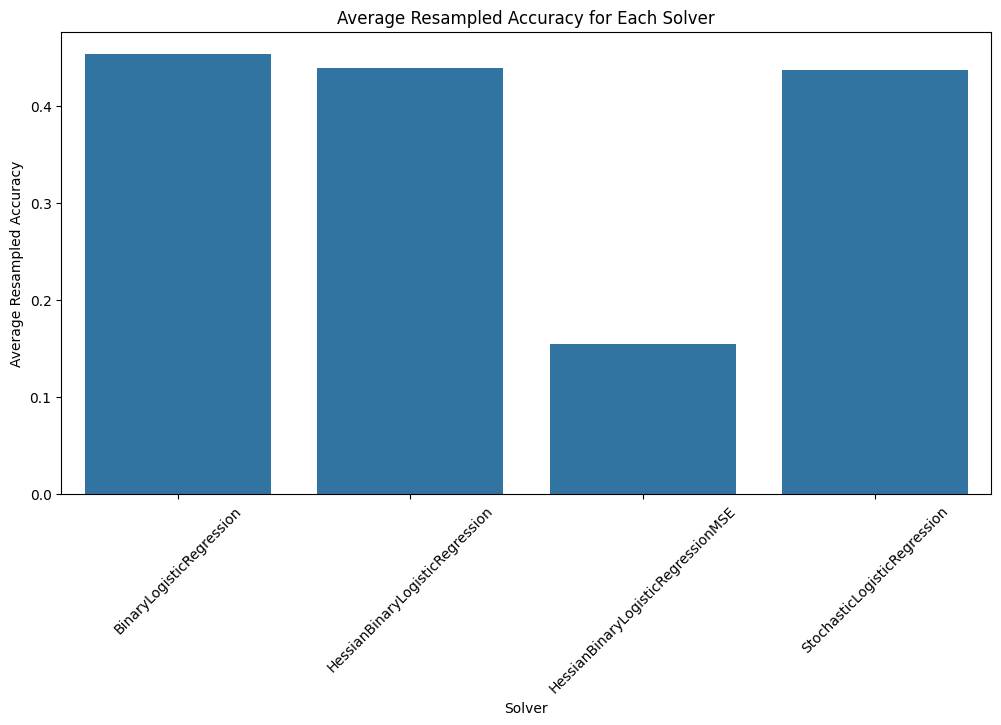

In [70]:
# Calculate the average mean_accuracy for each solver
accuracy_per_solver = (
    full_grid_results.groupby("solver_name")["accuracy_mean"]
    .mean()
    .reset_index()
)

# Create a barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=accuracy_per_solver,
    x="solver_name",
    y="accuracy_mean",
)
plt.xlabel("Solver")
plt.ylabel("Average Resampled Accuracy")
plt.title("Average Resampled Accuracy for Each Solver")
plt.xticks(rotation=45)
plt.show()

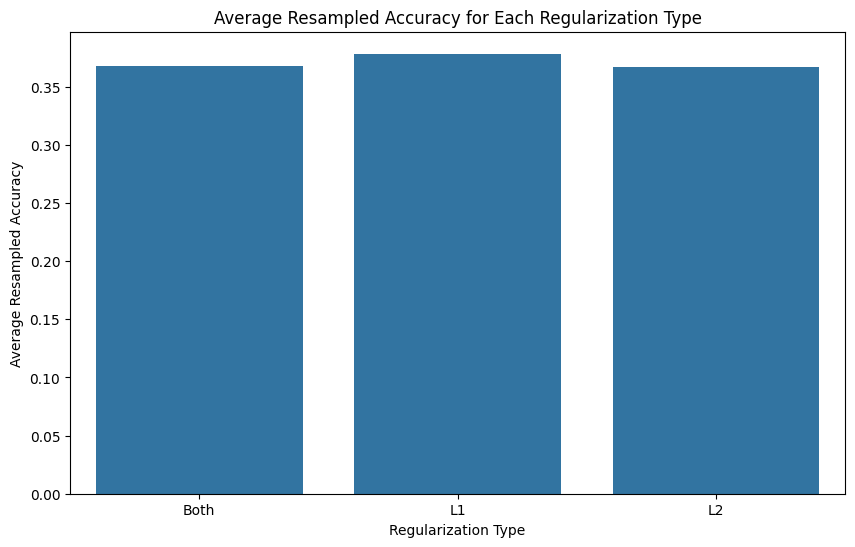

In [71]:
# Calculate the average mean_accuracy for each regularization type
accuracy_per_regularization = (
    full_grid_results.groupby("regularization")["accuracy_mean"]
    .mean()
    .reset_index()
)

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=accuracy_per_regularization,
    x="regularization",
    y="accuracy_mean",
)
plt.xlabel("Regularization Type")
plt.ylabel("Average Resampled Accuracy")
plt.title("Average Resampled Accuracy for Each Regularization Type")
plt.show()

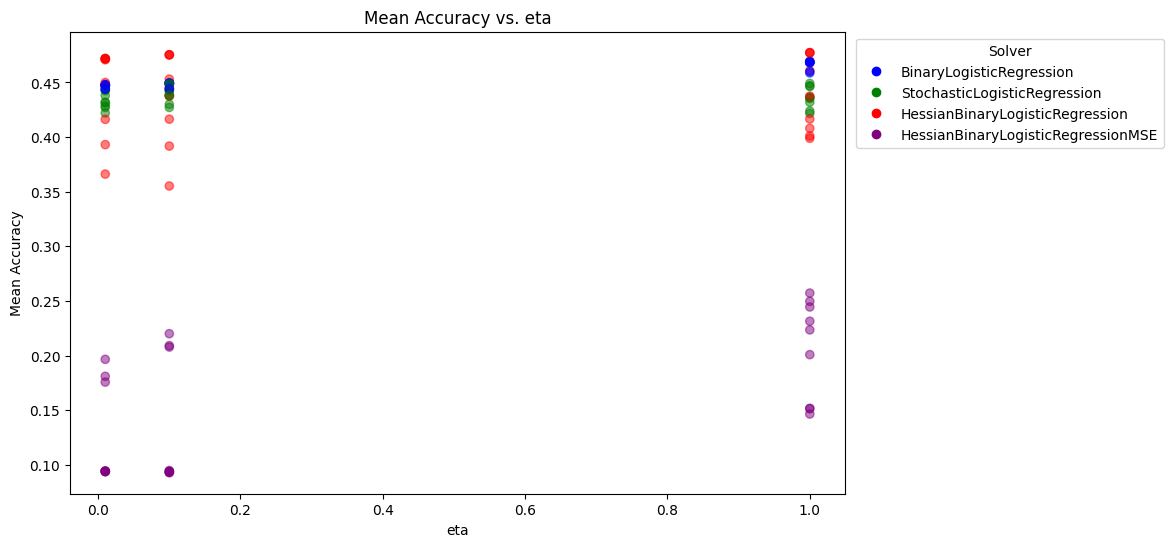

In [ ]:
# Visualize mean accuracy vs. eta
plt.figure(figsize=(10, 6))
plt.scatter(
    full_grid_results["eta"],
    full_grid_results["accuracy_mean"],
    c=full_grid_results["solver_name"].map(solver_colors),
    alpha=0.5,
)
plt.xlabel("eta")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. eta")
handles = [
    plt.plot([], [], marker="o", ls="", color=color)[0]
    for color in solver_colors.values()
]
labels = list(solver_colors.keys())
plt.legend(
    handles,
    labels,
    title="Solver",
    loc="upper right",
    bbox_to_anchor=(1.42, 1),
)
plt.show()

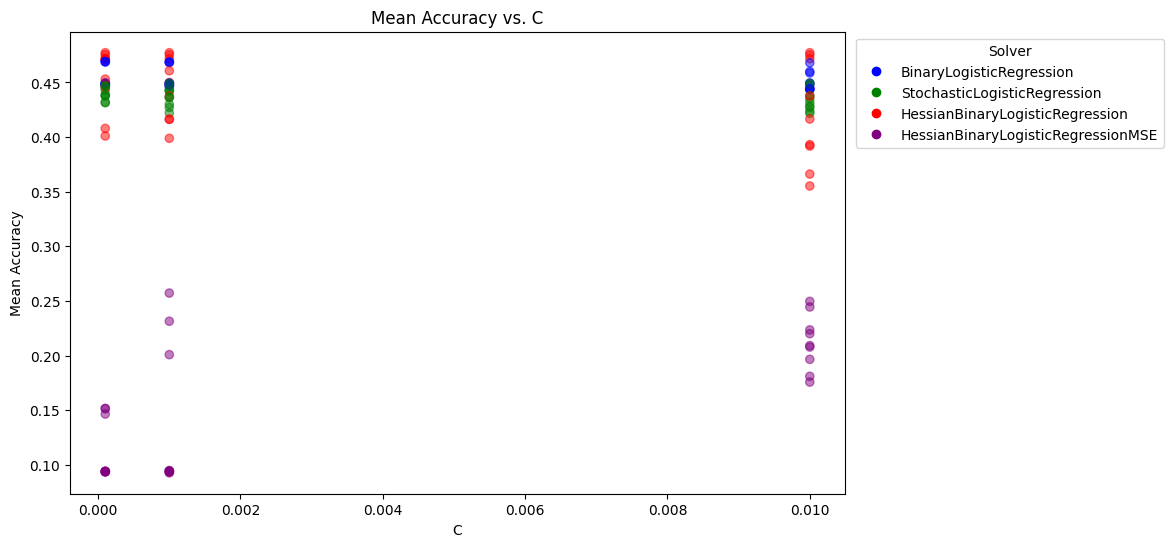

In [86]:
# Visualize mean accuracy vs. eta
plt.figure(figsize=(10, 6))
plt.scatter(
    full_grid_results["C"],
    full_grid_results["accuracy_mean"],
    c=full_grid_results["solver_name"].map(solver_colors),
    alpha=0.5,
)
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. C")
handles = [
    plt.plot([], [], marker="o", ls="", color=color)[0]
    for color in solver_colors.values()
]
labels = list(solver_colors.keys())
plt.legend(
    handles,
    labels,
    title="Solver",
    loc="upper right",
    bbox_to_anchor=(1.42, 1),
)
plt.show()

## References

https://www.fharrell.com/post/split-val/